0) 공통 설정 & 데이터 로드

In [5]:
# 0. Imports
import os, glob, random, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
# config
warnings.filterwarnings("ignore")
RANDOM_SEED = 42
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

DATA_ROOT = "./BTCUSDT-1m"
REQ_COLS = ["open_time","open","high","low","close","volume","close_time"]


In [8]:
def load_split(split_name):
    split_dir = os.path.join(DATA_ROOT, split_name)
    files = sorted(glob.glob(os.path.join(split_dir, "*.csv")))
    assert files, f"No files under {split_dir}"
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # 필수 컬럼 체크
        missing = [c for c in REQ_COLS if c not in df.columns]
        if missing: raise ValueError(f"{os.path.basename(f)} missing: {missing}")
        dfs.append(df)
    out = pd.concat(dfs, ignore_index=True)
    out = out.sort_values("open_time").reset_index(drop=True)
    return out
    

In [10]:
train = load_split("training")     # 2024
val   = load_split("validation")   # 2025-01
test  = load_split("test")         # 2025-02~04

for name, df in [("train",train),("val",val),("test",test)]:
    print(name, df.shape, df["open_time"].min(), "→", df["open_time"].max())
    

train (527040, 7) 1704067200000 → 1735689540000
val (44640, 7) 1735689600000 → 1738367940000
test (128160, 7) 1738368000000 → 1746057540000


1) 타깃 생성

In [11]:
# 1) 타깃 생성 함수 (과제 명시 규칙: 30분 뒤 가격 > 현재 가격 → 1, 아니면 0)
def create_target(df, horizon=30):
    """
    df: 시계열이 시간 오름차순으로 정렬된 DataFrame (open_time 기준)
    horizon: 몇 분 뒤의 종가를 볼 것인지 (기본 30)
    """
    df = df.copy()
    # 미래 종가: 현재 행 기준으로 horizon분 '뒤'의 close를 당겨오기 → shift(-horizon)
    df["future_price"] = df["close"].shift(-horizon)
    # 이진 라벨: 미래가 현재보다 크면 1(UP), 아니면 0(DOWN/같음)
    df["target"] = (df["future_price"] > df["close"]).astype(int)
    return df
    

In [12]:
# 2) 각 split에 독립적으로 적용 (데이터 누수 방지)
train = create_target(train, horizon=30).dropna()  # 맨 뒤 30개는 future_price가 NaN → 제거
val   = create_target(val,   horizon=30).dropna()
test  = create_target(test,  horizon=30).dropna()


In [13]:
# 3) 라벨 분포(클래스 불균형 여부) 빠른 확인
for name, df_ in [("train", train), ("val", val), ("test", test)]:
    dist = df_["target"].value_counts(normalize=True).round(3).to_dict()
    print(f"{name:>5} target dist:", dist)

# (선택) sanity check: 미래가격이 실제로 뒤쪽 행인지 인덱스로 확인
# 예: 임의의 구간에서 동일 인덱스 비교
i = 10_000
print(
    "예시 확인:",
    "현재close=", train.loc[i, "close"],
    "30분뒤close=", train.loc[i, "future_price"],
    "label=", train.loc[i, "target"]
)


train target dist: {1: 0.505, 0: 0.495}
  val target dist: {1: 0.501, 0: 0.499}
 test target dist: {1: 0.502, 0: 0.498}
예시 확인: 현재close= 43897.4 30분뒤close= 43929.4 label= 1


2) 특징공학

In [14]:
def add_features(df):
    df = df.copy()
    
    # 수익률(모멘텀)
    df["ret_1"] = df["close"].pct_change(1)
    df["ret_5"] = df["close"].pct_change(5)

    # 변동성
    df["vol_30"] = df["close"].pct_change().rolling(30).std()

    # 고가-저가 폭 (시장 변동 강도)
    df["range"] = df["high"] - df["low"]

    # 이동평균 (추세 반영)
    df["close_ma_30"] = df["close"].rolling(30).mean()
    df["volume_ma_30"] = df["volume"].rolling(30).mean()

    return df


In [15]:
train = add_features(train).dropna()
val   = add_features(val).dropna()
test  = add_features(test).dropna()

print(train.shape, val.shape, test.shape)


(526980, 15) (44580, 15) (128100, 15)


3) 정규화 스케일링

In [16]:
from sklearn.preprocessing import StandardScaler

# 사용할 피처 리스트 (11개)
FEATS = [
    "open","high","low","close","volume",
    "ret_1","ret_5","vol_30","range","close_ma_30","volume_ma_30"
]

X_tr, y_tr = train[FEATS].values, train["target"].values
X_va, y_va = val[FEATS].values,   val["target"].values
X_te, y_te = test[FEATS].values,  test["target"].values

# ⚠️ 스케일러는 train으로만 학습 (누수 방지)
scaler = StandardScaler().fit(X_tr)

X_tr = scaler.transform(X_tr)
X_va = scaler.transform(X_va)
X_te = scaler.transform(X_te)

X_tr.shape, X_va.shape, X_te.shape


((526980, 11), (44580, 11), (128100, 11))

4) 모델 학습

In [17]:
# Baseline 1. Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def eval_and_plot(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    print(f"[{name}] Acc={acc:.4f}  Prec={pre:.4f}  Rec={rec:.4f}  F1={f1:.4f}")
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(3.8,3.2))
    ax.matshow(cm)
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), va='center', ha='center')
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(f"{name} - Confusion Matrix")
    plt.show()
    return {"model": name, "acc":acc, "prec":pre, "rec":rec, "f1":f1}


[LogReg (val)] Acc=0.5152  Prec=0.5238  Rec=0.3512  F1=0.4205


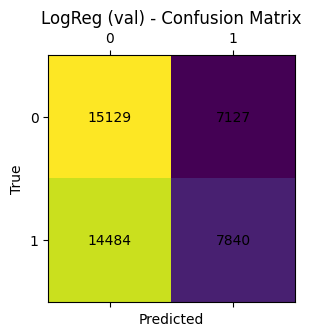

[LogReg (test)] Acc=0.5064  Prec=0.5109  Rec=0.4014  F1=0.4496


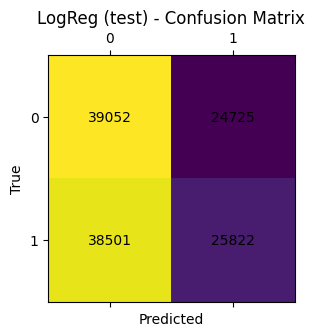

In [18]:
# 학습
lr = LogisticRegression(max_iter=1000, random_state=42)  # 클래스 불균형 없으므로 class_weight 생략
lr.fit(X_tr, y_tr)

# 검증셋 평가
lr_val_pred = lr.predict(X_va)
lr_val_row  = eval_and_plot("LogReg (val)", y_va, lr_val_pred)

# 테스트셋 최종 평가
lr_test_pred = lr.predict(X_te)
lr_test_row  = eval_and_plot("LogReg (test)", y_te, lr_test_pred)


[GradientBoosting (val)] Acc=0.5064  Prec=0.5084  Rec=0.4324  F1=0.4673


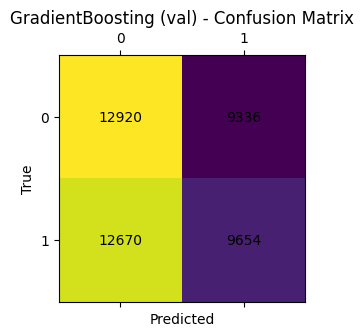

[GradientBoosting (test)] Acc=0.5134  Prec=0.5094  Rec=0.8419  F1=0.6347


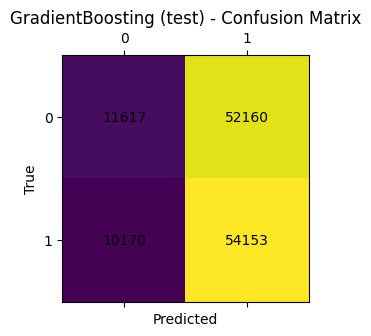

In [19]:
# Baseline 2. Gradient Boosting
# Step 5: Gradient Boosting (트리 기반 baseline)
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_tr, y_tr)

# 검증셋 평가
gb_val_pred = gb.predict(X_va)
gb_val_row  = eval_and_plot("GradientBoosting (val)", y_va, gb_val_pred)

# 테스트셋 최종 평가
gb_test_pred = gb.predict(X_te)
gb_test_row  = eval_and_plot("GradientBoosting (test)", y_te, gb_test_pred)


In [20]:
# Improved Model CNN + BiLSTM
# Step 6: Improved Model - CNN + BiLSTM
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# 6.1 시퀀스 윈도 생성 (최근 W분 데이터를 한 샘플로)
W = 60  # 최근 60분
d = len(FEATS)

def to_windows(df, feat_cols, W=60):
    X, y = [], []
    vals = df[feat_cols + ["target"]].values
    for i in range(len(vals)-W):
        X.append(vals[i:i+W, :-1])
        y.append(int(vals[i+W-1, -1]))
    return np.asarray(X), np.asarray(y)
    

In [21]:
def make_seq_arrays(df):
    tmp = df.copy()
    tmp[FEATS] = scaler.transform(tmp[FEATS])  # 동일 스케일러(누수 방지)
    return to_windows(tmp, FEATS, W=W)

Xtr_seq, ytr_seq = make_seq_arrays(train)
Xva_seq, yva_seq = make_seq_arrays(val)
Xte_seq, yte_seq = make_seq_arrays(test)

print("Seq shapes:", Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape)


Seq shapes: (526920, 60, 11) (44520, 60, 11) (128040, 60, 11)


In [22]:
# 6.2 모델 정의 (CNN → BiLSTM → Dense)
def build_cnn_bilstm(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, kernel_size=5, padding="same")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(64, kernel_size=3, padding="same")(x)
    x = layers.ReLU()(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC(name="auc")])
    return model


In [23]:
cnn_bilstm = build_cnn_bilstm((W, d))
early = tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True)

hist = cnn_bilstm.fit(
    Xtr_seq, ytr_seq,
    validation_data=(Xva_seq, yva_seq),
    epochs=30,
    batch_size=1024,   # Apple Silicon 성능에 따라 512~2048 조정 가능
    callbacks=[early],
    verbose=1
)


2025-11-11 20:30:42.596734: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-11-11 20:30:42.597150: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-11 20:30:42.597181: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-11 20:30:42.597592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-11 20:30:42.597648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2025-11-11 20:30:49.928412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


515/515 ━━━━━━━━━━━━━━━━━━━━ 755s 1s/step - auc: 0.5212 - loss: 0.6931 - val_auc: 0.5315 - val_loss: 0.6972
Epoch 2/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - auc: 0.5266 - loss: 0.6923 - val_auc: 0.5340 - val_loss: 0.6959
Epoch 3/30
 56/515 ━━━━━━━━━━━━━━━━━━━━ 10:45 1s/step - auc: 0.5239 - loss: 0.6933

KeyboardInterrupt: 

In [ ]:
# 6.3 임계값(threshold) 튜닝: 검증셋에서 F1이 최대인 threshold 사용
def best_threshold(probs, y_true):
    ths = np.linspace(0.3, 0.7, 41)  # 0.30~0.70
    best = (0.5, -1.0)
    for t in ths:
        pred = (probs >= t).astype(int)
        f1 = f1_score(y_true, pred, zero_division=0)
        if f1 > best[1]:
            best = (t, f1)
    return best

va_prob = cnn_bilstm.predict(Xva_seq, verbose=0).ravel()
t_opt, f1_opt = best_threshold(va_prob, yva_seq)
print(f"Best threshold on val = {t_opt:.2f} (F1={f1_opt:.4f})")


1) import & 설정

In [1]:
# 1. Imports & 재현성
import os, glob, random, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")
RANDOM_SEED = 42
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

DATA_ROOT = "./BTCUSDT-1m"
REQ_COLS = ["open_time","open","high","low","close","volume","close_time"]  # 기본 컬럼 예상


2) 데이터 로드 & 무결성 점검

In [2]:
# 2. split별 병합 로드
def load_split(split_dir):
    files = sorted(glob.glob(os.path.join(split_dir, "*.csv")))
    assert len(files) > 0, f"No files under {split_dir}"
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # 필수 컬럼 검사(이름 다르면 여기서 매핑 처리)
        missing = [c for c in REQ_COLS if c not in df.columns]
        if missing:
            raise ValueError(f"{os.path.basename(f)} missing columns: {missing}")
        dfs.append(df)
    out = pd.concat(dfs, ignore_index=True)
    out = out.sort_values("open_time").reset_index(drop=True)
    return out

train = load_split(os.path.join(DATA_ROOT, "training"))     # 2024
val   = load_split(os.path.join(DATA_ROOT, "validation"))   # 2025-01
test  = load_split(os.path.join(DATA_ROOT, "test"))         # 2025-02~04

# 기간/행수 확인
for name, df in [("train",train),("val",val),("test",test)]:
    print(name, df.shape, df["open_time"].min(), "→", df["open_time"].max())


train (527040, 7) 1704067200000 → 1735689540000
val (44640, 7) 1735689600000 → 1738367940000
test (128160, 7) 1738368000000 → 1746057540000


3) 타깃 생성 + 누수 방지 

In [3]:
# 3. 타깃 생성(절대 바꾸지 않기)
def create_target(df, horizon=30):
    df = df.copy()
    df["future_price"] = df["close"].shift(-horizon)
    df["target"] = (df["future_price"] > df["close"]).astype(int)
    return df

train = create_target(train).dropna()
val   = create_target(val).dropna()
test  = create_target(test).dropna()

for name, df in [("train",train),("val",val),("test",test)]:
    print(name, "target dist:", df["target"].value_counts(normalize=True).round(3).to_dict())


train target dist: {1: 0.505, 0: 0.495}
val target dist: {1: 0.501, 0: 0.499}
test target dist: {1: 0.502, 0: 0.498}


4) 특징공학

In [4]:
# 4. 간단 파생변수(성능↑ + Innovation 설명 근거로 좋음)
def add_features(df):
    df = df.copy()
    # 모멘텀/변동성/범위
    df["ret_1"] = df["close"].pct_change(1)
    df["ret_5"] = df["close"].pct_change(5)
    df["vol_30"] = df["close"].pct_change().rolling(30).std()
    df["range"] = df["high"] - df["low"]
    # 롤링 요약(최근 30분)
    df["close_ma_30"] = df["close"].rolling(30).mean()
    df["volume_ma_30"] = df["volume"].rolling(30).mean()
    return df

train = add_features(train).dropna()
val   = add_features(val).dropna()
test  = add_features(test).dropna()

FEATS = ["open","high","low","close","volume","ret_1","ret_5","vol_30","range","close_ma_30","volume_ma_30"]
X_tr, y_tr = train[FEATS].values, train["target"].values
X_va, y_va = val[FEATS].values,   val["target"].values
X_te, y_te = test[FEATS].values,  test["target"].values

# 스케일링(훈련셋으로만 적합)
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr); X_va = scaler.transform(X_va); X_te = scaler.transform(X_te)

X_tr.shape, X_va.shape, X_te.shape


((526980, 11), (44580, 11), (128100, 11))

5) 공통 평가 함수

In [5]:
# 5. 평가 유틸
def eval_and_report(model, X, y, name="model"):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    pre = precision_score(y, pred, zero_division=0)
    rec = recall_score(y, pred, zero_division=0)
    f1  = f1_score(y, pred, zero_division=0)
    return {"model":name,"acc":acc,"prec":pre,"rec":rec,"f1":f1}, pred

def plot_confmat(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(3.8,3.2))
    ax.matshow(cm)
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), va='center', ha='center')
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    plt.show()


6) ML 베이스라인 2개 + 단순 로지스틱

In [6]:
results = []

# (A) RandomForest
rf = RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=RANDOM_SEED)
rf.fit(X_tr, y_tr)
r_va, p_va = eval_and_report(rf, X_va, y_va, "RandomForest (val)")
results.append(r_va)

# (B) GradientBoosting
gb = GradientBoostingClassifier(random_state=RANDOM_SEED)
gb.fit(X_tr, y_tr)
g_va, g_pred = eval_and_report(gb, X_va, y_va, "GradientBoosting (val)")
results.append(g_va)

# (C) LogisticRegression (선형 기준선)
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_SEED)
lr.fit(X_tr, y_tr)
l_va, l_pred = eval_and_report(lr, X_va, y_va, "LogReg (val)")
results.append(l_va)

pd.DataFrame(results).sort_values("f1", ascending=False)


,model,acc,prec,rec,f1
0,RandomForest (val),0.505473,0.506640,0.475094,0.490360
1,GradientBoosting (val),0.506371,0.508373,0.432449,0.467348
2,LogReg (val),0.514266,0.533367,0.239876,0.330923


7) 개선 모델 : CNN + BiLSTM 하이브리드

In [ ]:
# 7. DL 개선 모델: CNN + BiLSTM
# 윈도 길이 W와 입력 차원 d
W = 60
d = len(FEATS)

def to_windows(df, feat_cols, W=60):
    X, y = [], []
    vals = df[feat_cols + ["target"]].values
    for i in range(len(vals)-W):
        X.append(vals[i:i+W, :-1])
        y.append(vals[i+W-1, -1])
    X = np.asarray(X); y = np.asarray(y).astype(int)
    return X, y

# 시계열 윈도 생성(스케일러 적용 후 재구성)
def make_seq_arrays(df):
    tmp = df.copy()
    tmp[FEATS] = scaler.transform(tmp[FEATS])  # 누수 방지: scaler는 train으로 적합된 것 사용
    return to_windows(tmp, FEATS, W=W)

Xtr_seq, ytr_seq = make_seq_arrays(train)
Xva_seq, yva_seq = make_seq_arrays(val)
Xte_seq, yte_seq = make_seq_arrays(test)

print("Seq shapes:", Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape)

# Keras 모델
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_bilstm(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=32, kernel_size=5, padding="same")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.ReLU()(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC(name="auc")])
    return model

cnn_bilstm = build_cnn_bilstm((W, d))
cb_ckpt = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True)
hist = cnn_bilstm.fit(
    Xtr_seq, ytr_seq,
    validation_data=(Xva_seq, yva_seq),
    epochs=30, batch_size=1024,
    callbacks=[cb_ckpt], verbose=1
)

# 검증셋 평가(F1은 threshold 0.5 기준)
va_prob = cnn_bilstm.predict(Xva_seq, verbose=0).ravel()
va_pred = (va_prob >= 0.5).astype(int)
cb_va = {
    "model":"CNN+BiLSTM (val)",
    "acc": accuracy_score(yva_seq, va_pred),
    "prec": precision_score(yva_seq, va_pred, zero_division=0),
    "rec": recall_score(yva_seq, va_pred, zero_division=0),
    "f1": f1_score(yva_seq, va_pred, zero_division=0)
}
pd.DataFrame([cb_va])


8) 최종 테스트셋 평가 (모든 모델)

In [ ]:
final_rows = []

# ML 3종
for name, mdl in [("RF", rf), ("GB", gb), ("LR", lr)]:
    row, pred = eval_and_report(mdl, X_te, y_te, f"{name} (test)")
    final_rows.append(row)
    plot_confmat(y_te, pred, f"{name} (test)")

# 개선 DL
te_prob = cnn_bilstm.predict(Xte_seq, verbose=0).ravel()
te_pred = (te_prob >= 0.5).astype(int)
final_rows.append({
    "model":"CNN+BiLSTM (test)",
    "acc": accuracy_score(yte_seq, te_pred),
    "prec": precision_score(yte_seq, te_pred, zero_division=0),
    "rec": recall_score(yte_seq, te_pred, zero_division=0),
    "f1": f1_score(yte_seq, te_pred, zero_division=0)
})
plot_confmat(yte_seq, te_pred, "CNN+BiLSTM (test)")

summary = pd.DataFrame(final_rows).sort_values("f1", ascending=False)
summary


9) 성능 비교 그래프

In [ ]:
plt.figure(figsize=(6,3.5))
bar_x = np.arange(len(summary))
plt.bar(bar_x-0.3, summary["acc"], width=0.2, label="Acc")
plt.bar(bar_x-0.1, summary["prec"], width=0.2, label="Prec")
plt.bar(bar_x+0.1, summary["rec"], width=0.2, label="Rec")
plt.bar(bar_x+0.3, summary["f1"],  width=0.2, label="F1")
plt.xticks(bar_x, summary["model"], rotation=15)
plt.legend(); plt.title("Model comparison on TEST")
plt.tight_layout(); plt.show()
